In this project, we'll build a simple convolutional neural network for CIFAR-10 image classification. Code contained in this project was based on Tensorflow 1.2.1 and python 3.5. 

In [1]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import tarfile
import tensorflow as tf

cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 6:
Image - Min Value: 7 Max Value: 249
Image - Shape: (32, 32, 3)
Label - Label Id: 2 Name: bird


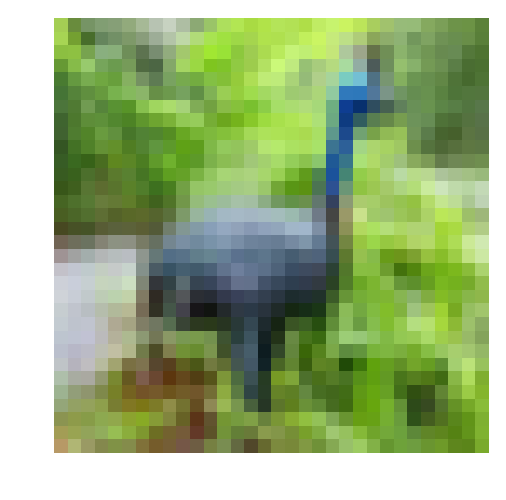

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 6
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

# Preprocess Data

## Normalize

In [3]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    """
    return (x - np.mean(x)) / np.std(x)
    # return ( x - x.min() ) / ( x.max() - x.min() )

## One hot encode

In [4]:
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    smooth_factor = 0.1
    output = np.zeros([len(x), 10]) # +( 0.1 / 9 )
    for idx, item in enumerate(x):
        output[idx, item] = 1. # - smooth_factor
    return output

This above function is equivalent to tf.one_hot(x, 10), but tensorflow module can not be pickled so we're sticking with the above implementation.

## Preprocess Data
We will randomly shuffle the data, normalize them and save them in binary format.

In [5]:
import tensorflow as tf
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# Checkpoint
The above work is all saved so when we're revisiting this notebook we don't have to do those work again. We can start from here.

In [6]:
import pickle
import helper

valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))
valid_features = normalize(valid_features)

# Building the network

## Defining input

In [7]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    """
    return tf.placeholder(tf.float32, [None, image_shape[0], image_shape[1], image_shape[2]], "x")


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    """
    return tf.placeholder(tf.float32, [None, n_classes], "y")


def neural_net_keep_prob_input(n):
    """
    Return a Tensor for keep probability
    """
    return tf.placeholder(tf.float32, None, "keep_prob_"+str(n))


def neural_net_training_flag():
    return tf.placeholder(tf.bool, None, "train_flag")

## Convolution and maxpool layer

In [8]:
def conv2d(x_tensor, conv_num_outputs, conv_ksize, conv_strides, is_train):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    w = tf.get_variable("w", shape=[conv_ksize[0], conv_ksize[1], x_tensor.get_shape().as_list()[3], conv_num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    #b = tf.Variable(tf.truncated_normal([conv_num_outputs],
    #                                  mean=0.0, stddev=0.1, dtype=tf.float32))
    
    wc = tf.nn.conv2d(x_tensor, w, strides=[1, conv_strides[0], conv_strides[1], 1], padding='SAME')
    # z = tf.nn.bias_add(wc, b)
    z = tf.layers.batch_normalization(wc, training=is_train)
    
    return tf.nn.relu(z)



## Flatten layer
Implement the flatten function to change the dimension of x_tensor from a 4-D tensor to a 2-D tensor. The output should be the shape (Batch Size, Flattened Image Size). Shortcut option: you can use classes from the TensorFlow Layers or TensorFlow Layers (contrib) packages for this layer. For more of a challenge, only use other TensorFlow packages.

In [9]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # reference : https://github.com/tensorflow/tensorflow/issues/7253
    return tf.reshape(x_tensor, [tf.shape(x_tensor)[0], np.prod(x_tensor.get_shape().as_list()[1:])])
    
    # This also works
    #return tf.reshape(x_tensor, [-1, np.prod(x_tensor.shape[1:]).value])

## Fully connected layer

In [10]:
def fully_conn(x_tensor, num_outputs, is_train):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    fc = tf.reshape(x_tensor, [-1, np.prod(x_tensor.get_shape().as_list()[1:])])
    
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    # b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    z = tf.matmul(fc, w)
    z = tf.layers.batch_normalization(z, training=is_train)
    
    return tf.nn.relu(z)

## Output layer

In [11]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    w = tf.get_variable("w", shape=[np.prod(x_tensor.get_shape().as_list()[1:]), num_outputs],
                         initializer=tf.contrib.layers.xavier_initializer())
    
    b = tf.Variable(tf.truncated_normal([num_outputs],mean=0.0, stddev=0.1, dtype=tf.float32))
    return tf.nn.softmax(tf.add(tf.matmul(x_tensor, w), b))


## Create the convolutional neural network model

In [12]:
def conv_net(x, keep_prob_1, keep_prob_2, keep_prob_3, keep_prob_4,  train_flag):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    
    # Convolution and maxpooling layers
    with tf.variable_scope("conv1"):
        conv1 = conv2d(x, 64, (3, 3), (1, 1), train_flag)
    conv1 = tf.nn.dropout(conv1, keep_prob_1)
    with tf.variable_scope("conv1s"):
        conv1s = conv2d(conv1, 64, (3, 3), (1, 1), train_flag)
    conv1s = tf.nn.max_pool(conv1s, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv1s = tf.nn.dropout(conv1s, keep_prob_1)
    
    with tf.variable_scope("conv2"):
        conv2 = conv2d(conv1s, 128, (3, 3), (1, 1), train_flag)
    conv2 = tf.nn.dropout(conv2, keep_prob_2)
    with tf.variable_scope("conv2s"):
        conv2s = conv2d(conv2, 128, (3, 3), (1, 1), train_flag)
    conv2s = tf.nn.max_pool(conv2s, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv2s = tf.nn.dropout(conv2s, keep_prob_2)
    
    with tf.variable_scope("conv3"):
        conv3 = conv2d(conv2s, 256, (3, 3), (1, 1), train_flag)
    conv3 = tf.nn.dropout(conv3, keep_prob_3)
    with tf.variable_scope("conv3s"):
        conv3s = conv2d(conv3, 256, (3, 3), (1, 1), train_flag)
    conv3s = tf.nn.dropout(conv3s, keep_prob_3)
    with tf.variable_scope("conv3t"):
        conv3t = conv2d(conv3s, 256, (3, 3), (1, 1), train_flag)
    conv3t = tf.nn.max_pool(conv3t, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv3t = tf.nn.dropout(conv3t, keep_prob_3)
    
    with tf.variable_scope("conv4"):
        conv4 = conv2d(conv3s, 512, (3, 3), (1, 1), train_flag)
    conv4 = tf.nn.dropout(conv4, keep_prob_4)
    with tf.variable_scope("conv4s"):
        conv4s = conv2d(conv4, 512, (3, 3), (1, 1), train_flag)
    conv4s = tf.nn.dropout(conv4s, keep_prob_4)
    with tf.variable_scope("conv4t"):
        conv4t = conv2d(conv4s, 512, (3, 3), (1, 1), train_flag)
    conv4t = tf.nn.max_pool(conv4t, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    conv4t = tf.nn.dropout(conv4t, keep_prob_4)
    
    
    # Flatten Layer
    f = flatten(conv4t)

    # Fully Connected layers
    with tf.variable_scope("fc1"):
        fc1 = fully_conn(f, 512, train_flag)
        fc1 = tf.nn.dropout(fc1, keep_prob_4)
    with tf.variable_scope("fc2"):
        fc2 = fully_conn(fc1, 512, train_flag)
        fc2 = tf.nn.dropout(fc2, keep_prob_4)
    #with tf.variable_scope("fc3"):
    #    fc3 = fully_conn(fc2, 256, train_flag)
    #    fc3 = tf.nn.dropout(fc3, keep_prob_4)
    
    # Output Layer
    with tf.variable_scope("out"):
        o = output(fc2, 10)
    
    # TODO: return output
    return o


## Build the network

In [13]:
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob_1 = neural_net_keep_prob_input(1)
keep_prob_2 = neural_net_keep_prob_input(2)
keep_prob_3 = neural_net_keep_prob_input(3)
keep_prob_4 = neural_net_keep_prob_input(4)
train_flag = neural_net_training_flag()

# Model
logits = conv_net(x, keep_prob_1, keep_prob_2, keep_prob_3, keep_prob_4, train_flag)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

# Collect batch mean and variance for batch normalization
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

## Train network

In [14]:
def train_neural_network(session, optimizer, kp1, kp2, kp3, kp4, feature_batch, label_batch, is_train):
    """
    Optimize the session on a batch of images and labels
    """
    session.run(optimizer, feed_dict={x: feature_batch, 
                                      y: label_batch, 
                                      keep_prob_1: kp1,
                                      keep_prob_2: kp2,
                                      keep_prob_3: kp3,
                                      keep_prob_4: kp4,
                                      train_flag:is_train})

## Print Stats
It's important to evaluate the performance of model once in a while. If effect, we're feeding a small batch of data to the neural network through forward propagation and then caculate the accuracy of prediction. We don't want to do this too often as this slows down the overall process. It's important to keep in mind that since we're actually using the model for prediction but not training it, we need to set keep probability for dropout to 1 so we're not losing any connection between neurons. 

In [15]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    """
    Print information about loss and validation accuracy
    """
    loss = session.run(cost, feed_dict={x: feature_batch, 
                                        y: label_batch, 
                                        keep_prob_1: 1., 
                                        keep_prob_2: 1.,
                                        keep_prob_3: 1.,
                                        keep_prob_4: 1.,
                                        train_flag:False})
    valid_acc = session.run(accuracy, feed_dict={x: valid_features, 
                                                 y: valid_labels, 
                                                 keep_prob_1: 1., 
                                                 keep_prob_2: 1.,
                                                 keep_prob_3: 1.,
                                                 keep_prob_4: 1.,
                                                 train_flag:False})
    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss, valid_acc))

## Hyperparameters

In [16]:
epochs = 200
batch_size = 64
kp1 = 0.8
kp2 = 0.7
kp3 = 0.6
kp4 = 0.5

## Train on a single CIFAR-10 batch

In [17]:
#print('Checking the Training on a Single Batch...')
#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
    
    # Training cycle
#    for epoch in range(epochs):
#        batch_i = 1
#        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
#            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels, True)
#        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
#        print_stats(sess, batch_features, batch_labels, cost, accuracy)

## Fully train the model
Deep structure 11 layers, withFliplr, Gaussian Blur, Crop, and Affine, 200 Epochs : 91.1 %

In [18]:
import helper
import imgaug as ia
from imgaug import augmenters as iaa
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

save_model_path = './image_classification'


print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                
                seq = iaa.Sequential([iaa.Fliplr(0.5),
                                      iaa.GaussianBlur(0, 3.0),
                                      iaa.Crop(px=(0, 2)),
                                      iaa.Sometimes(0.5, iaa.Affine(rotate=(-45, 45),
                                                                    shear=(-16, 16),
                                                                    order=[0, 1],
                                                                    cval=(0, 255),
                                                                    mode=ia.ALL))
                                     ], random_order=True)
                batch_features = seq.augment_images(batch_features)
                
                batch_mean = np.mean(batch_features)
                batch_std = np.std(batch_features)
                batch_features = batch_features.astype(np.float32)
                for ii in range(batch_features.shape[0]):
                    
                    batch_features[ii, :, :, :] = (batch_features[ii, :, :, :] - batch_mean) / batch_std                     
                train_neural_network(sess, optimizer, kp1, kp2, kp3, kp4, batch_features, batch_labels, True)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:     3.6496 Validation Accuracy: 0.095800
Epoch  1, CIFAR-10 Batch 2:  Loss:     2.1166 Validation Accuracy: 0.326000
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.7831 Validation Accuracy: 0.368400
Epoch  1, CIFAR-10 Batch 4:  Loss:     2.1078 Validation Accuracy: 0.361200
Epoch  1, CIFAR-10 Batch 5:  Loss:     2.3064 Validation Accuracy: 0.372200
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.8641 Validation Accuracy: 0.409200
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.9235 Validation Accuracy: 0.492800
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.3952 Validation Accuracy: 0.494800
Epoch  2, CIFAR-10 Batch 4:  Loss:     1.1235 Validation Accuracy: 0.589800
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.4607 Validation Accuracy: 0.531600
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.0950 Validation Accuracy: 0.592200
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.3730 Validation Accuracy: 0.608000
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.8790 Validation Accuracy: 0.638200


Epoch 22, CIFAR-10 Batch 4:  Loss:     0.1932 Validation Accuracy: 0.869800
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.1350 Validation Accuracy: 0.872600
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.5635 Validation Accuracy: 0.863400
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.3513 Validation Accuracy: 0.870600
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.3118 Validation Accuracy: 0.867400
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.1611 Validation Accuracy: 0.876200
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.4357 Validation Accuracy: 0.866600
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.5272 Validation Accuracy: 0.864600
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.2226 Validation Accuracy: 0.871400
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.2079 Validation Accuracy: 0.870400
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.2379 Validation Accuracy: 0.874800
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.2326 Validation Accuracy: 0.871200
Epoch 25, CIFAR-10 Batch 1:  Loss:     0.3752 Validation Accuracy: 0.869400
Epoch 25, CI

Epoch 44, CIFAR-10 Batch 2:  Loss:     0.1769 Validation Accuracy: 0.872200
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.0323 Validation Accuracy: 0.895000
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.0738 Validation Accuracy: 0.894400
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.1013 Validation Accuracy: 0.884000
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.1348 Validation Accuracy: 0.893200
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.2102 Validation Accuracy: 0.888800
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.1247 Validation Accuracy: 0.890600
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.2195 Validation Accuracy: 0.898000
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.1406 Validation Accuracy: 0.894800
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.1236 Validation Accuracy: 0.898000
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.0993 Validation Accuracy: 0.901400
Epoch 46, CIFAR-10 Batch 3:  Loss:     0.0882 Validation Accuracy: 0.891800
Epoch 46, CIFAR-10 Batch 4:  Loss:     0.0832 Validation Accuracy: 0.902000
Epoch 46, CI

Epoch 65, CIFAR-10 Batch 5:  Loss:     0.0846 Validation Accuracy: 0.903600
Epoch 66, CIFAR-10 Batch 1:  Loss:     0.1345 Validation Accuracy: 0.903400
Epoch 66, CIFAR-10 Batch 2:  Loss:     0.1280 Validation Accuracy: 0.893600
Epoch 66, CIFAR-10 Batch 3:  Loss:     0.0399 Validation Accuracy: 0.901600
Epoch 66, CIFAR-10 Batch 4:  Loss:     0.0550 Validation Accuracy: 0.897200
Epoch 66, CIFAR-10 Batch 5:  Loss:     0.0385 Validation Accuracy: 0.900800
Epoch 67, CIFAR-10 Batch 1:  Loss:     0.1077 Validation Accuracy: 0.901600
Epoch 67, CIFAR-10 Batch 2:  Loss:     0.1940 Validation Accuracy: 0.913600
Epoch 67, CIFAR-10 Batch 3:  Loss:     0.0631 Validation Accuracy: 0.901400
Epoch 67, CIFAR-10 Batch 4:  Loss:     0.0989 Validation Accuracy: 0.904600
Epoch 67, CIFAR-10 Batch 5:  Loss:     0.0759 Validation Accuracy: 0.904600
Epoch 68, CIFAR-10 Batch 1:  Loss:     0.0689 Validation Accuracy: 0.902400
Epoch 68, CIFAR-10 Batch 2:  Loss:     0.0964 Validation Accuracy: 0.907000
Epoch 68, CI

Epoch 87, CIFAR-10 Batch 3:  Loss:     0.0148 Validation Accuracy: 0.900800
Epoch 87, CIFAR-10 Batch 4:  Loss:     0.1153 Validation Accuracy: 0.907400
Epoch 87, CIFAR-10 Batch 5:  Loss:     0.0300 Validation Accuracy: 0.903600
Epoch 88, CIFAR-10 Batch 1:  Loss:     0.0833 Validation Accuracy: 0.895400
Epoch 88, CIFAR-10 Batch 2:  Loss:     0.1674 Validation Accuracy: 0.906200
Epoch 88, CIFAR-10 Batch 3:  Loss:     0.0299 Validation Accuracy: 0.897600
Epoch 88, CIFAR-10 Batch 4:  Loss:     0.1061 Validation Accuracy: 0.903200
Epoch 88, CIFAR-10 Batch 5:  Loss:     0.0582 Validation Accuracy: 0.899400
Epoch 89, CIFAR-10 Batch 1:  Loss:     0.0523 Validation Accuracy: 0.905600
Epoch 89, CIFAR-10 Batch 2:  Loss:     0.0170 Validation Accuracy: 0.905600
Epoch 89, CIFAR-10 Batch 3:  Loss:     0.0244 Validation Accuracy: 0.905000
Epoch 89, CIFAR-10 Batch 4:  Loss:     0.0384 Validation Accuracy: 0.908200
Epoch 89, CIFAR-10 Batch 5:  Loss:     0.0065 Validation Accuracy: 0.903400
Epoch 90, CI

Epoch 108, CIFAR-10 Batch 5:  Loss:     0.0208 Validation Accuracy: 0.906600
Epoch 109, CIFAR-10 Batch 1:  Loss:     0.0499 Validation Accuracy: 0.902800
Epoch 109, CIFAR-10 Batch 2:  Loss:     0.0451 Validation Accuracy: 0.905400
Epoch 109, CIFAR-10 Batch 3:  Loss:     0.0301 Validation Accuracy: 0.904600
Epoch 109, CIFAR-10 Batch 4:  Loss:     0.0705 Validation Accuracy: 0.903400
Epoch 109, CIFAR-10 Batch 5:  Loss:     0.0113 Validation Accuracy: 0.908400
Epoch 110, CIFAR-10 Batch 1:  Loss:     0.0341 Validation Accuracy: 0.914200
Epoch 110, CIFAR-10 Batch 2:  Loss:     0.3154 Validation Accuracy: 0.910600
Epoch 110, CIFAR-10 Batch 3:  Loss:     0.0105 Validation Accuracy: 0.913600
Epoch 110, CIFAR-10 Batch 4:  Loss:     0.0498 Validation Accuracy: 0.902600
Epoch 110, CIFAR-10 Batch 5:  Loss:     0.0616 Validation Accuracy: 0.901200
Epoch 111, CIFAR-10 Batch 1:  Loss:     0.0359 Validation Accuracy: 0.909800
Epoch 111, CIFAR-10 Batch 2:  Loss:     0.0354 Validation Accuracy: 0.908600

Epoch 130, CIFAR-10 Batch 2:  Loss:     0.0319 Validation Accuracy: 0.909600
Epoch 130, CIFAR-10 Batch 3:  Loss:     0.0637 Validation Accuracy: 0.908400
Epoch 130, CIFAR-10 Batch 4:  Loss:     0.0649 Validation Accuracy: 0.906200
Epoch 130, CIFAR-10 Batch 5:  Loss:     0.0329 Validation Accuracy: 0.909400
Epoch 131, CIFAR-10 Batch 1:  Loss:     0.0686 Validation Accuracy: 0.908000
Epoch 131, CIFAR-10 Batch 2:  Loss:     0.0837 Validation Accuracy: 0.905000
Epoch 131, CIFAR-10 Batch 3:  Loss:     0.0208 Validation Accuracy: 0.907000
Epoch 131, CIFAR-10 Batch 4:  Loss:     0.0708 Validation Accuracy: 0.906000
Epoch 131, CIFAR-10 Batch 5:  Loss:     0.0037 Validation Accuracy: 0.911600
Epoch 132, CIFAR-10 Batch 1:  Loss:     0.0254 Validation Accuracy: 0.910600
Epoch 132, CIFAR-10 Batch 2:  Loss:     0.0147 Validation Accuracy: 0.908200
Epoch 132, CIFAR-10 Batch 3:  Loss:     0.0377 Validation Accuracy: 0.907000
Epoch 132, CIFAR-10 Batch 4:  Loss:     0.0972 Validation Accuracy: 0.908200

Epoch 151, CIFAR-10 Batch 4:  Loss:     0.1442 Validation Accuracy: 0.912200
Epoch 151, CIFAR-10 Batch 5:  Loss:     0.0485 Validation Accuracy: 0.903400
Epoch 152, CIFAR-10 Batch 1:  Loss:     0.0886 Validation Accuracy: 0.908600
Epoch 152, CIFAR-10 Batch 2:  Loss:     0.1858 Validation Accuracy: 0.912200
Epoch 152, CIFAR-10 Batch 3:  Loss:     0.0014 Validation Accuracy: 0.907800
Epoch 152, CIFAR-10 Batch 4:  Loss:     0.0344 Validation Accuracy: 0.908600
Epoch 152, CIFAR-10 Batch 5:  Loss:     0.0278 Validation Accuracy: 0.909800
Epoch 153, CIFAR-10 Batch 1:  Loss:     0.0249 Validation Accuracy: 0.910800
Epoch 153, CIFAR-10 Batch 2:  Loss:     0.0510 Validation Accuracy: 0.914800
Epoch 153, CIFAR-10 Batch 3:  Loss:     0.0115 Validation Accuracy: 0.900800
Epoch 153, CIFAR-10 Batch 4:  Loss:     0.0096 Validation Accuracy: 0.911800
Epoch 153, CIFAR-10 Batch 5:  Loss:     0.0274 Validation Accuracy: 0.905600
Epoch 154, CIFAR-10 Batch 1:  Loss:     0.1132 Validation Accuracy: 0.912200

Epoch 173, CIFAR-10 Batch 1:  Loss:     0.0430 Validation Accuracy: 0.905000
Epoch 173, CIFAR-10 Batch 2:  Loss:     0.0275 Validation Accuracy: 0.906400
Epoch 173, CIFAR-10 Batch 3:  Loss:     0.0049 Validation Accuracy: 0.910400
Epoch 173, CIFAR-10 Batch 4:  Loss:     0.0265 Validation Accuracy: 0.909800
Epoch 173, CIFAR-10 Batch 5:  Loss:     0.0321 Validation Accuracy: 0.912400
Epoch 174, CIFAR-10 Batch 1:  Loss:     0.0912 Validation Accuracy: 0.908600
Epoch 174, CIFAR-10 Batch 2:  Loss:     0.0415 Validation Accuracy: 0.911400
Epoch 174, CIFAR-10 Batch 3:  Loss:     0.0064 Validation Accuracy: 0.908200
Epoch 174, CIFAR-10 Batch 4:  Loss:     0.0660 Validation Accuracy: 0.906200
Epoch 174, CIFAR-10 Batch 5:  Loss:     0.0480 Validation Accuracy: 0.910600
Epoch 175, CIFAR-10 Batch 1:  Loss:     0.0117 Validation Accuracy: 0.907800
Epoch 175, CIFAR-10 Batch 2:  Loss:     0.0183 Validation Accuracy: 0.914000
Epoch 175, CIFAR-10 Batch 3:  Loss:     0.0093 Validation Accuracy: 0.907200

Epoch 194, CIFAR-10 Batch 3:  Loss:     0.0178 Validation Accuracy: 0.910200
Epoch 194, CIFAR-10 Batch 4:  Loss:     0.0261 Validation Accuracy: 0.908600
Epoch 194, CIFAR-10 Batch 5:  Loss:     0.0089 Validation Accuracy: 0.911000
Epoch 195, CIFAR-10 Batch 1:  Loss:     0.0065 Validation Accuracy: 0.900000
Epoch 195, CIFAR-10 Batch 2:  Loss:     0.0563 Validation Accuracy: 0.909000
Epoch 195, CIFAR-10 Batch 3:  Loss:     0.0288 Validation Accuracy: 0.908400
Epoch 195, CIFAR-10 Batch 4:  Loss:     0.0052 Validation Accuracy: 0.907000
Epoch 195, CIFAR-10 Batch 5:  Loss:     0.0032 Validation Accuracy: 0.911800
Epoch 196, CIFAR-10 Batch 1:  Loss:     0.0478 Validation Accuracy: 0.905400
Epoch 196, CIFAR-10 Batch 2:  Loss:     0.0229 Validation Accuracy: 0.904400
Epoch 196, CIFAR-10 Batch 3:  Loss:     0.0175 Validation Accuracy: 0.907000
Epoch 196, CIFAR-10 Batch 4:  Loss:     0.0265 Validation Accuracy: 0.910600
Epoch 196, CIFAR-10 Batch 5:  Loss:     0.0141 Validation Accuracy: 0.908400

## Test model

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.9019705414012739



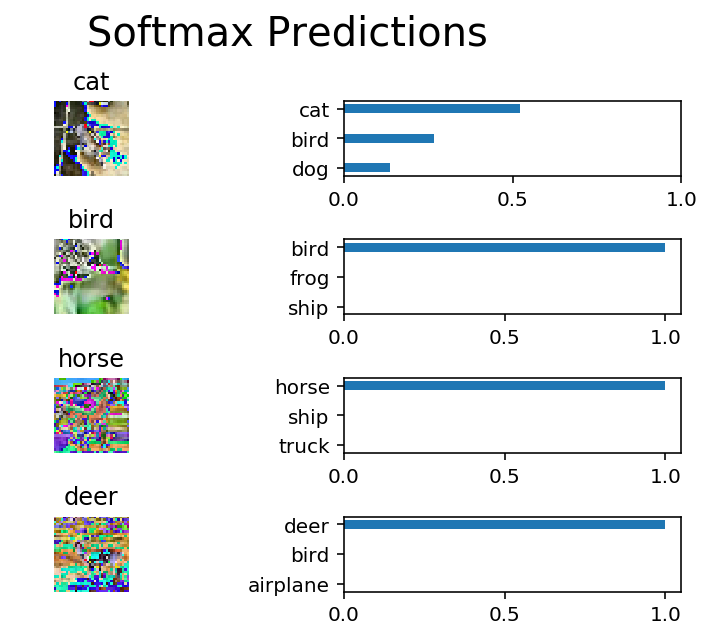

In [19]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """
    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()
    test_features = test_features.astype(np.float32)
    batch_mean = np.mean(test_features)
    batch_std = np.std(test_features)
    for ii in range(test_features.shape[0]):
        test_features[ii,:,:,:] = (test_features[ii,:,:,:] - batch_mean) / batch_std

    
    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob_1 = loaded_graph.get_tensor_by_name('keep_prob_1:0')
        loaded_keep_prob_2 = loaded_graph.get_tensor_by_name('keep_prob_2:0')
        loaded_keep_prob_3 = loaded_graph.get_tensor_by_name('keep_prob_3:0')
        loaded_keep_prob_4 = loaded_graph.get_tensor_by_name('keep_prob_4:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        loaded_train_flag = loaded_graph.get_tensor_by_name('train_flag:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            
            
            test_batch_acc_total += sess.run(loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, 
                           loaded_keep_prob_1: 1.0, loaded_keep_prob_2: 1.0,
                           loaded_keep_prob_3: 1.0, loaded_keep_prob_4: 1.0,
                           loaded_train_flag:False})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        
        random_test_predictions = sess.run(tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, 
                       loaded_keep_prob_1: 1.0, loaded_keep_prob_2: 1.0,
                        loaded_keep_prob_3: 1.0, loaded_keep_prob_4: 1.0,
                       loaded_train_flag:False})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

test_model()